<a href="https://colab.research.google.com/github/limedosa/Cryptocurrency-Price-Prediction/blob/main/Cryptocurrency_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cryptocurrency Price Prediction

# New Section

In [ ]:
# check for Python >= 3.8
import sys
assert sys.version_info >= (3, 8)

# Install necessary libraries
!pip install scikit-learn matplotlib numpy pandas xgboost

# Do all necessary imports
import os
import sklearn
import xgboost

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
# !pip install alpaca-trade-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Successfully uninstalled msgpack-1.0.8
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


# Mount Data
I made this data myself with Alpaca.


In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data explanation:
I used Alpaca to get cryptocurrency daily data from 2020-2024 for the following cryptos:

* BTC (Bitcoin)
* ETH (Ethereum)
* ADA (Cardano)
* XRP (XRP)
* DOGE (Dogecoin)
* LTC (Litecoin)
* BCH (Bitcoin Cash)
* LINK (Chainlink)
* BNB (Binance Coin)
* MATIC (Polygon)

Dates I used:
(3/7/2020) - (3/7/2024)

* volume => how much of crypto traded during day


In [ ]:
import pandas as pd

In [ ]:
# Import splitting function
from sklearn.model_selection import train_test_split
# data = pd.read_csv("/content/drive/MyDrive/Data spring '24/cryptoData 2020-2024.csv")

# NOTE sub for:
data = pd.read_csv("cryptoData 2020-2024.csv")


train_set, test_set = train_test_split(data, test_size=0.2, random_state=37)

df= train_set

print(f"data size={len(data)}; training size={len(train_set)}; testing size={len(test_set)}")
df.head()

data size=7870; training size=6296; testing size=1574


,cryptoName,Date,open,high,low,close,volume
7183,MATIC/USD,2021/08/06,1.04190,1.1511,1.04190,1.127600,1.710668e+07
698,BTC/USD,2022/11/30,16861.30000,17244.0000,16707.41000,17112.200000,9.202328e+03
5363,BCH/USD,2022/12/21,100.77000,101.3300,99.88000,100.810000,3.677746e+02
5378,BCH/USD,2023/01/05,103.17000,103.1700,100.13000,100.370000,1.199314e+03
6821,LINK/USD,2023/10/14,7.28945,7.3784,7.21835,7.330785,6.639395e-01


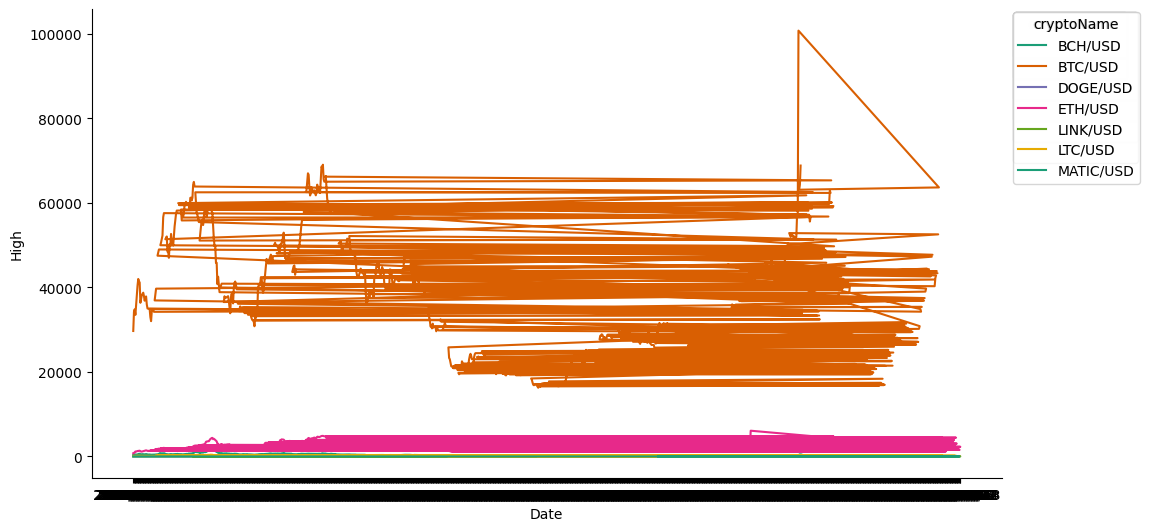

In [ ]:
# @title Date vs high

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['high']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('cryptoName')):
  _plot_series(series, series_name, i)
  fig.legend(title='cryptoName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('High')


# Data Cleaning
Minimal data cleaning is necessary because all the variables are important.


*  rename 'Date' to be 'date' just for consistency
*  since all data is in USD, remove the /USD part from the crypto names
* make sure all data points are on the same scale and have the same number of decimal points => e.g. volume seems to have more decimal points



In [ ]:
#RENAME VARIABLES

df.rename(columns={'Date': 'date'}, inplace=True)
df['cryptoName']=df['cryptoName'].str.split('/USD').str[0]
# df.drop('cryptoName', axis=1,inplace=True)
# df.rename(columns={'cryptoNameNew': 'cryptoName'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df

,cryptoName,date,open,high,low,close,volume
7183,MATIC,2021-08-06,1.04190,1.151100,1.041900,1.127600,1.710668e+07
698,BTC,2022-11-30,16861.30000,17244.000000,16707.410000,17112.200000,9.202328e+03
5363,BCH,2022-12-21,100.77000,101.330000,99.880000,100.810000,3.677746e+02
5378,BCH,2023-01-05,103.17000,103.170000,100.130000,100.370000,1.199314e+03
6821,LINK,2023-10-14,7.28945,7.378400,7.218350,7.330785,6.639395e-01
...,...,...,...,...,...,...,...
988,BTC,2023-09-16,26560.03900,26618.545000,26440.705000,26562.576000,1.932679e+00
6395,LINK,2022-08-14,9.17540,9.370400,8.561900,8.956400,2.131710e+05
844,BTC,2023-04-25,27432.28000,28603.497841,27208.300645,28350.330500,7.514282e+03
4459,LTC,2023-09-04,64.45195,64.491050,63.050000,63.284500,1.014673e+00


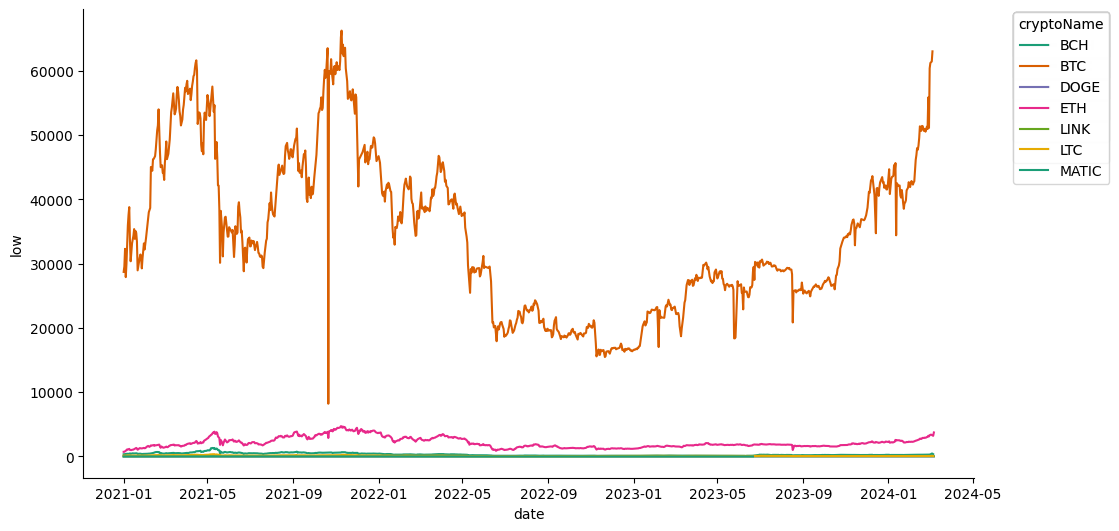

In [ ]:
# @title date vs low

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['low']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('cryptoName')):
  _plot_series(series, series_name, i)
  fig.legend(title='cryptoName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('low')

In [ ]:
df.columns

Index(['cryptoName', 'date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [ ]:
df

,cryptoName,date,open,high,low,close,volume
7183,MATIC,2021-08-06,1.04190,1.151100,1.041900,1.127600,1.710668e+07
698,BTC,2022-11-30,16861.30000,17244.000000,16707.410000,17112.200000,9.202328e+03
5363,BCH,2022-12-21,100.77000,101.330000,99.880000,100.810000,3.677746e+02
5378,BCH,2023-01-05,103.17000,103.170000,100.130000,100.370000,1.199314e+03
6821,LINK,2023-10-14,7.28945,7.378400,7.218350,7.330785,6.639395e-01
...,...,...,...,...,...,...,...
988,BTC,2023-09-16,26560.03900,26618.545000,26440.705000,26562.576000,1.932679e+00
6395,LINK,2022-08-14,9.17540,9.370400,8.561900,8.956400,2.131710e+05
844,BTC,2023-04-25,27432.28000,28603.497841,27208.300645,28350.330500,7.514282e+03
4459,LTC,2023-09-04,64.45195,64.491050,63.050000,63.284500,1.014673e+00


In [ ]:
import plotly.graph_objects as go

# Fig 1 plots candlestick charts for multiple cryptocurrencies over time.
# Each candlestick represents the trading activity of a single day and
# contains information about the opening, closing, highest, and lowest
# prices within that day.

fig1 = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig1.show()



In [ ]:
fig1.update_layout(
    title="Cryptocurrency Candlestick Charts",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark"
)

fig1.show()


In [ ]:
fig2 = go.Figure(
    data=[go.Candlestick(x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'])]
)

fig2.update_layout(
    title="Cryptocurrency Candlestick Charts",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark"
)

fig2.show()


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date']

7183   2021-08-06
698    2022-11-30
5363   2022-12-21
5378   2023-01-05
6821   2023-10-14
          ...    
988    2023-09-16
6395   2022-08-14
844    2023-04-25
4459   2023-09-04
1935   2023-02-14
Name: date, Length: 6296, dtype: datetime64[ns]

In [ ]:
import plotly.graph_objects as go

fig2 = go.Figure(
    data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig2.show()


fig2.update_layout(
    title="Cryptocurrency Candlestick Charts",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark"
)

fig2.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig2.show()
# Each candlestick chart will have a label indicating the cryptocurrency symbol.
# The legend is placed at the top of the plot. This makes it easier to identify which cryptocurrency
# each candlestick chart represents.






In [ ]:
df.columns

Index(['cryptoName', 'date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

# One hot encode cryto name

In [ ]:
# # One hot encoding
# from sklearn.preprocessing import OneHotEncoder

# # Get columns to transform.
# categorical_col_names = ['cryptoName'] # stored as a separate variable for later.
# categorical = df[categorical_col_names]

# # Do one hot encoding.
# encoder = OneHotEncoder()
# categorical_one_hot = encoder.fit_transform(categorical)
# categorical_one_hot.toarray()

In [ ]:
# categorical_one_hot_df = pd.DataFrame(categorical_one_hot.toarray(), columns=encoder.get_feature_names_out(categorical_col_names))
# df = pd.concat([df, categorical_one_hot_df], axis=1)

# Drop the original categorical column, if needed
# df = df.drop(categorical_col_names, axis=1)

df

,cryptoName,date,open,high,low,close,volume
7183,MATIC,2021-08-06,1.04190,1.151100,1.041900,1.127600,1.710668e+07
698,BTC,2022-11-30,16861.30000,17244.000000,16707.410000,17112.200000,9.202328e+03
5363,BCH,2022-12-21,100.77000,101.330000,99.880000,100.810000,3.677746e+02
5378,BCH,2023-01-05,103.17000,103.170000,100.130000,100.370000,1.199314e+03
6821,LINK,2023-10-14,7.28945,7.378400,7.218350,7.330785,6.639395e-01
...,...,...,...,...,...,...,...
988,BTC,2023-09-16,26560.03900,26618.545000,26440.705000,26562.576000,1.932679e+00
6395,LINK,2022-08-14,9.17540,9.370400,8.561900,8.956400,2.131710e+05
844,BTC,2023-04-25,27432.28000,28603.497841,27208.300645,28350.330500,7.514282e+03
4459,LTC,2023-09-04,64.45195,64.491050,63.050000,63.284500,1.014673e+00


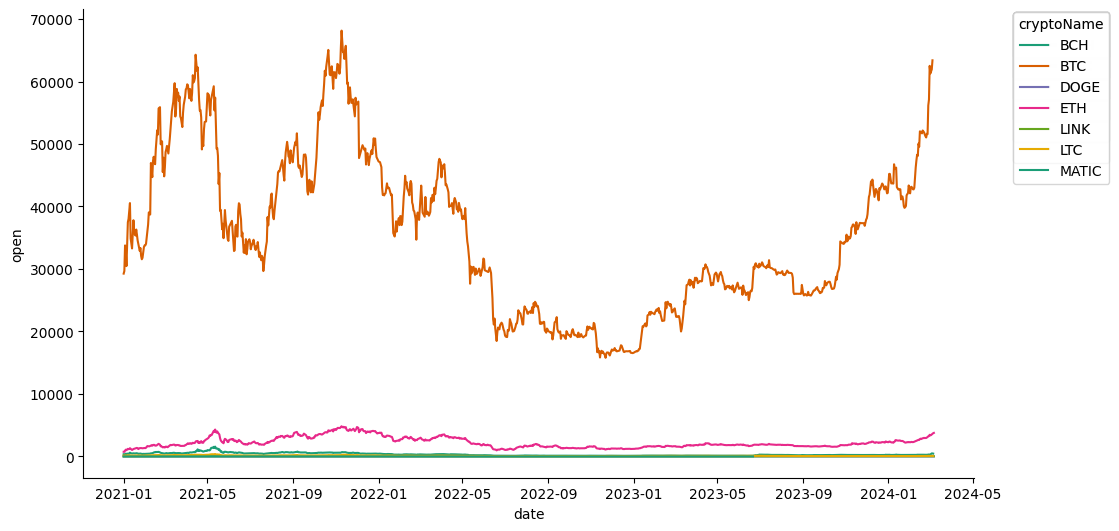

In [ ]:
# @title date vs open

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['open']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_set.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('cryptoName')):
  _plot_series(series, series_name, i)
  fig.legend(title='cryptoName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('open')

In [ ]:
# @title Making new df variables in training df


df['average'] = (df['low']+df['high']/2)

df['change'] = df['high'] - df['low']

df['openClose'] = df['open']-df['close']


df['close'] = pd.to_numeric(df['close'], errors='coerce')

# get daily return
df['dailyReturn'] = df['close'].pct_change()*100

#get volatility
volatility = df['dailyReturn'].std()

print(f"volatility: {volatility:.2f}%")

df.rename(columns={'Date': 'date'}, inplace=True)
df['cryptoName']=df['cryptoName'].str.split('/USD').str[0]

df['date'] = pd.to_datetime(df['date'])


df['dayOfWeek'] = df['date'].dt.dayofweek

df['lagBy1Day'] = df['close'].shift(1)

df['lagBy1Day']= df['lagBy1Day'].fillna(0) #made error when it had Nan => turned into 0

df['lagByWeek'] = df['close'].shift(7)

df['lagByWeek']= df['lagByWeek'].fillna(0)

df = df.fillna(0.0)

df['date'] = pd.to_datetime(df['date'])



volatility: 10052085.82%


In [ ]:
#dropping low and high bc/ we used them for average
df.drop(['low','high'], axis=1, inplace=True)
df

,cryptoName,date,open,close,volume,average,change,openClose,dailyReturn,dayOfWeek,lagBy1Day,lagByWeek
7183,MATIC,2021-08-06,1.04190,1.127600,1.710668e+07,1.617450,0.109200,-0.085700,0.000000e+00,4,0.0000,0.000
698,BTC,2022-11-30,16861.30000,17112.200000,9.202328e+03,25329.410000,536.590000,-250.900000,1.517477e+06,2,1.1276,0.000
5363,BCH,2022-12-21,100.77000,100.810000,3.677746e+02,150.545000,1.450000,-0.040000,-9.941089e+01,2,17112.2000,0.000
5378,BCH,2023-01-05,103.17000,100.370000,1.199314e+03,151.715000,3.040000,2.800000,-4.364646e-01,3,100.8100,0.000
6821,LINK,2023-10-14,7.28945,7.330785,6.639395e-01,10.907550,0.160050,-0.041335,-9.269624e+01,5,100.3700,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
988,BTC,2023-09-16,26560.03900,26562.576000,1.932679e+00,39749.977500,177.840000,-2.537000,3.862293e+04,5,68.5965,599.120
6395,LINK,2022-08-14,9.17540,8.956400,2.131710e+05,13.247100,0.808500,0.219000,-9.996628e+01,6,26562.5760,179.910
844,BTC,2023-04-25,27432.28000,28350.330500,7.514282e+03,41510.049565,1395.197196,-918.050500,3.164371e+05,1,8.9564,6.844
4459,LTC,2023-09-04,64.45195,63.284500,1.014673e+00,95.295525,1.441050,1.167450,-9.977678e+01,0,28350.3305,305.450


In [ ]:
# @title Making new df variables in testing df
testDF = test_set


testDF['average'] = (testDF['low']+testDF['high']/2)

testDF['change'] = testDF['high'] - testDF['low']

testDF['openClose'] = testDF['open']-testDF['close']


testDF['close'] = pd.to_numeric(testDF['close'], errors='coerce')

# get daily return
testDF['dailyReturn'] = testDF['close'].pct_change()*100

#get volatility
volatility = testDF['dailyReturn'].std()

print(f"volatility: {volatility:.2f}%")

testDF.rename(columns={'Date': 'date'}, inplace=True)
testDF['cryptoName']=testDF['cryptoName'].str.split('/USD').str[0]

testDF['date'] = pd.to_datetime(testDF['date'])


testDF['dayOfWeek'] = testDF['date'].dt.dayofweek

testDF['lagBy1Day'] = testDF['close'].shift(1)

testDF['lagBy1Day']= testDF['lagBy1Day'].fillna(0) #made error when it had Nan => turned into 0

testDF['lagByWeek'] = testDF['close'].shift(7)

testDF['lagByWeek']= testDF['lagByWeek'].fillna(0)

testDF = testDF.fillna(0.0)

testDF['date'] = pd.to_datetime(testDF['date'])


testDF

volatility: 6560351.53%


,cryptoName,date,open,high,low,close,volume,average,change,openClose,dailyReturn,dayOfWeek,lagBy1Day,lagByWeek
3270,DOGE,2023-08-07,0.075209,0.075209,0.071640,0.073735,2.068432e+04,0.109245,0.003569,0.001475,0.000000,0,0.000000,0.000000
3454,DOGE,2024-02-07,0.078485,0.080394,0.078192,0.080028,6.285615e+04,0.118389,0.002202,-0.001543,8.535384,2,0.073735,0.000000
3067,DOGE,2023-01-16,0.087300,0.087585,0.081500,0.084000,3.019352e+07,0.125292,0.006085,0.003300,4.962869,0,0.080028,0.000000
4297,LTC,2023-03-26,93.506190,95.958500,91.888945,92.628565,1.275543e+04,139.868195,4.069555,0.877625,110172.101488,6,0.084000,0.000000
591,BTC,2022-08-15,24861.370000,24992.730000,23780.000000,23966.910000,8.366048e+03,36276.365000,1212.730000,894.460000,25774.210548,0,92.628565,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,BTC,2023-08-01,28855.495381,30016.816015,28584.430105,29661.684475,1.652534e+00,43592.838112,1432.385910,-806.189093,21711.665913,1,135.990000,0.883000
4117,LTC,2022-09-27,54.820000,55.560000,51.020000,52.010000,1.239580e+04,78.800000,4.540000,2.810000,-99.824656,1,29661.684475,0.070088
7794,MATIC,2023-04-09,1.106017,1.155906,1.084000,1.092930,8.132244e+05,1.661953,0.071906,0.013087,-97.898616,6,52.010000,132.710000
2952,DOGE,2022-09-23,0.062000,0.068300,0.059200,0.066100,5.688237e+07,0.093350,0.009100,-0.004100,-93.952037,4,1.092930,105.320000


In [ ]:
#dropping low and high bc/ we used them for average
testDF.drop(['low','high'], axis=1, inplace=True)
testDF

,cryptoName,date,open,close,volume,average,change,openClose,dailyReturn,dayOfWeek,lagBy1Day,lagByWeek
3270,DOGE,2023-08-07,0.075209,0.073735,2.068432e+04,0.109245,0.003569,0.001475,0.000000,0,0.000000,0.000000
3454,DOGE,2024-02-07,0.078485,0.080028,6.285615e+04,0.118389,0.002202,-0.001543,8.535384,2,0.073735,0.000000
3067,DOGE,2023-01-16,0.087300,0.084000,3.019352e+07,0.125292,0.006085,0.003300,4.962869,0,0.080028,0.000000
4297,LTC,2023-03-26,93.506190,92.628565,1.275543e+04,139.868195,4.069555,0.877625,110172.101488,6,0.084000,0.000000
591,BTC,2022-08-15,24861.370000,23966.910000,8.366048e+03,36276.365000,1212.730000,894.460000,25774.210548,0,92.628565,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
942,BTC,2023-08-01,28855.495381,29661.684475,1.652534e+00,43592.838112,1432.385910,-806.189093,21711.665913,1,135.990000,0.883000
4117,LTC,2022-09-27,54.820000,52.010000,1.239580e+04,78.800000,4.540000,2.810000,-99.824656,1,29661.684475,0.070088
7794,MATIC,2023-04-09,1.106017,1.092930,8.132244e+05,1.661953,0.071906,0.013087,-97.898616,6,52.010000,132.710000
2952,DOGE,2022-09-23,0.062000,0.066100,5.688237e+07,0.093350,0.009100,-0.004100,-93.952037,4,1.092930,105.320000


In [ ]:
# @title Finding missing values => no missing values, which is great!
for i in df:
  print(i, df[i].isnull().sum())

cryptoName 0
date 0
open 0
close 0
volume 0
average 0
change 0
openClose 0
dailyReturn 0
dayOfWeek 0
lagBy1Day 0
lagByWeek 0


In [ ]:
df.columns

Index(['cryptoName', 'date', 'open', 'close', 'volume', 'average', 'change',
       'openClose', 'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')

In [ ]:
# @title Linear Regression Model: Uses yesterday's closing price to predict today's closing price
# @markdown * This model uses *'open'*, *'average'*, and *'lag by 1 day'* as it's features to predict the closing price.
# @markdown * The model has a MSE of 214,799 and a R-squared of .99.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score


def closingPriceLinearRegression(trainLabels, labelUsing):
  """
  Given specific training labels and a label to test for, train data
  """
  # doing linear regression
  model = LinearRegression()

  # using train and test we developed earlier
  train, test = df, testDF

  # train
  X_train, y_train = train[trainLabels], train[labelUsing]
  X_test, y_test = test[trainLabels], test[labelUsing]


  model.fit(X_train, y_train)

  # finding MSE and r squared
  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  print(f'Mean Squared Error: {mse}')
  print(f'R-squared: {r2}')

trainLabels = ['lagBy1Day', 'open']
labelUsing = 'close'
closingPriceLinearRegression(trainLabels, labelUsing)


Mean Squared Error: 214799.667285554
R-squared: 0.9988508899612891


In [ ]:
# !pip install category_encoders

In [ ]:
# # @title Grouped data to find aggregated stats on crypto


# dfVars = df[['cryptoName', 'date', 'open', 'high', 'low', 'close', 'volume', 'average', 'change', 'openClose']]

# dfGroupedStats = dfVars.groupby('cryptoName').agg(
#     num_samples=('date', 'count'), #gets num times crpto appeared
#     total_volume=('volume', 'sum'), #find total amount of times crypto was traded
#     max_close=('close', 'max'),
#     min_close = ('close', 'min'),
#     max_open=('open', 'max'),
#     min_open = ('open', 'min'),
#     averageCost = ('average', 'mean'),


# )

# dfGroupedStats = dfGroupedStats.reset_index()

# dfGroupedStats['averageVolume'] = dfGroupedStats['total_volume'] / dfGroupedStats['num_samples']
# dfGroupedStats['diffClose'] = dfGroupedStats['max_close'] - dfGroupedStats['min_close']
# dfGroupedStats['diffOpen'] = dfGroupedStats['max_open'] - dfGroupedStats['min_open']

# #sort by 'average_volume'
# dfGroupedStats = dfGroupedStats.sort_values('averageVolume')


# dfGroupedStats


In [ ]:
# # @title Grouped data to find aggregated stats on crypto testing data


# dfVarsTest = testDF[['cryptoName', 'date', 'open', 'high', 'low', 'close', 'volume', 'average', 'change', 'openClose']]

# dfGroupedStatsTest = dfVarsTest.groupby('cryptoName').agg(
#     num_samples=('date', 'count'), #gets num times crpto appeared
#     total_volume=('volume', 'sum'), #find total amount of times crypto was traded
#     max_close=('close', 'max'),
#     min_close = ('close', 'min'),
#     max_open=('open', 'max'),
#     min_open = ('open', 'min'),
#     averageCost = ('average', 'mean'),

# )

# dfGroupedStatsTest = dfGroupedStatsTest.reset_index()
# dfGroupedStatsTest['averageVolume'] = dfGroupedStatsTest['total_volume'] / dfGroupedStatsTest['num_samples']
# dfGroupedStatsTest['diffClose'] = dfGroupedStatsTest['max_close'] - dfGroupedStatsTest['min_close']
# dfGroupedStatsTest['diffOpen'] = dfGroupedStatsTest['max_open'] - dfGroupedStatsTest['min_open']
# #sort by 'average_volume'
# dfGroupedStatsTest = dfGroupedStatsTest.sort_values('averageVolume')
# dfGroupedStatsTest

In [ ]:
df.columns

df.dtypes

cryptoName             object
date           datetime64[ns]
open                  float64
close                 float64
volume                float64
average               float64
change                float64
openClose             float64
dailyReturn           float64
dayOfWeek               int64
lagBy1Day             float64
lagByWeek             float64
dtype: object

In [ ]:
# @title Transforming date to be int
df = df.astype({'date': 'int64'})

testDF= df.astype({'date': 'int64'})


In [ ]:
# @title Data Standardization

#extract numerical cols
dfStandardized = df.copy()
numericalColumns = dfStandardized.select_dtypes(include=['float64', 'int64']).columns

# standardize numerical cols
dfStandardized[numericalColumns] = (dfStandardized[numericalColumns] - dfStandardized[numericalColumns].mean()) / dfStandardized[numericalColumns].std()
dfStandardized

,cryptoName,date,open,close,volume,average,change,openClose,dailyReturn,dayOfWeek,lagBy1Day,lagByWeek
7183,MATIC,-1.049641,-0.420359,-0.420281,-0.002497,-0.420426,-0.243389,0.004832,-0.117270,0.508143,-0.420344,-0.419855
698,BTC,0.410142,0.847262,0.865369,-0.137940,0.863573,0.153504,-0.468332,0.033703,-0.491160,-0.420259,-0.419855
5363,BCH,0.473875,-0.412861,-0.412791,-0.138010,-0.412876,-0.242397,0.004918,-0.117280,-0.491160,0.865381,-0.419855
5378,BCH,0.519399,-0.412681,-0.412824,-0.138004,-0.412817,-0.241221,0.010276,-0.117270,0.008492,-0.412770,-0.419855
6821,LINK,1.375238,-0.419889,-0.419815,-0.138013,-0.419955,-0.243351,0.004916,-0.117279,1.007794,-0.412803,-0.419855
...,...,...,...,...,...,...,...,...,...,...,...,...
988,BTC,1.290261,1.576451,1.575427,-0.138013,1.594627,-0.111902,0.000208,-0.113428,1.007794,-0.415190,-0.374822
6395,LINK,0.082374,-0.419748,-0.419692,-0.136324,-0.419837,-0.242872,0.005407,-0.117280,1.507445,1.575435,-0.406332
844,BTC,0.853237,1.642030,1.709751,-0.137954,1.683854,0.788709,-1.726921,-0.085788,-0.990811,-0.419671,-0.419340
4459,LTC,1.253843,-0.415592,-0.415611,-0.138013,-0.415677,-0.242404,0.007196,-0.117280,-1.490462,1.709758,-0.396895


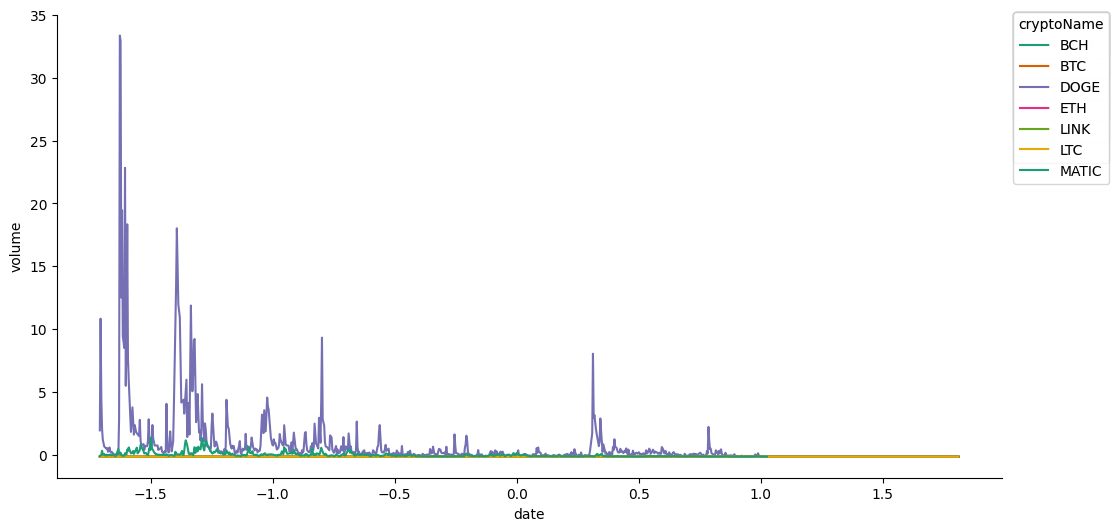

In [ ]:
# @title date vs volume

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['volume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dfStandardized.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('cryptoName')):
  _plot_series(series, series_name, i)
  fig.legend(title='cryptoName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('volume')

In [ ]:
# @title Data Standardization for Testing Data

#extract numerical cols
dfStandardizedTest = testDF.copy()
numerical_columns = dfStandardizedTest.select_dtypes(include=['float64', 'int64']).columns

# standardize numerical cols
dfStandardizedTest[numerical_columns] = (dfStandardizedTest[numerical_columns] - dfStandardizedTest[numerical_columns].mean()) / dfStandardizedTest[numerical_columns].std()
dfStandardizedTest

,cryptoName,date,open,close,volume,average,change,openClose,dailyReturn,dayOfWeek,lagBy1Day,lagByWeek
7183,MATIC,-1.049641,-0.420359,-0.420281,-0.002497,-0.420426,-0.243389,0.004832,-0.117270,0.508143,-0.420344,-0.419855
698,BTC,0.410142,0.847262,0.865369,-0.137940,0.863573,0.153504,-0.468332,0.033703,-0.491160,-0.420259,-0.419855
5363,BCH,0.473875,-0.412861,-0.412791,-0.138010,-0.412876,-0.242397,0.004918,-0.117280,-0.491160,0.865381,-0.419855
5378,BCH,0.519399,-0.412681,-0.412824,-0.138004,-0.412817,-0.241221,0.010276,-0.117270,0.008492,-0.412770,-0.419855
6821,LINK,1.375238,-0.419889,-0.419815,-0.138013,-0.419955,-0.243351,0.004916,-0.117279,1.007794,-0.412803,-0.419855
...,...,...,...,...,...,...,...,...,...,...,...,...
988,BTC,1.290261,1.576451,1.575427,-0.138013,1.594627,-0.111902,0.000208,-0.113428,1.007794,-0.415190,-0.374822
6395,LINK,0.082374,-0.419748,-0.419692,-0.136324,-0.419837,-0.242872,0.005407,-0.117280,1.507445,1.575435,-0.406332
844,BTC,0.853237,1.642030,1.709751,-0.137954,1.683854,0.788709,-1.726921,-0.085788,-0.990811,-0.419671,-0.419340
4459,LTC,1.253843,-0.415592,-0.415611,-0.138013,-0.415677,-0.242404,0.007196,-0.117280,-1.490462,1.709758,-0.396895


In [ ]:
dfStandardized.columns

Index(['cryptoName', 'date', 'open', 'close', 'volume', 'average', 'change',
       'openClose', 'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')

In [ ]:
dfStandardizedTest.columns

Index(['cryptoName', 'date', 'open', 'close', 'volume', 'average', 'change',
       'openClose', 'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')

In [ ]:
# @title Data prep based on example

# First, separate features from target variable(s).
features = dfStandardized.drop("cryptoName", axis=1)
target = dfStandardized["cryptoName"]


In [ ]:
# # One hot encoding
# from sklearn.preprocessing import OneHotEncoder

# # Get columns to transform.
# categorical_col_names = ['cryptoName'] # stored as a separate variable for later.
# categorical = features[categorical_col_names]

# # Do one hot encoding.
# encoder = OneHotEncoder()
# categorical_one_hot = encoder.fit_transform(categorical)
# categorical_one_hot.toarray()

# print(categorical_one_hot[10])

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
# Get columns to transform.
numerical_col_names = [c for c in features.columns] # stored as a separate variable for later.
numerical = features[numerical_col_names]

# Print missing count
print("Num missing before imputation:", np.count_nonzero(np.isnan(numerical)))

# Do transformation.
imputer = SimpleImputer(strategy="median")
imputed_numerical = imputer.fit_transform(numerical)

# Print missing count. Should be 0.
print("Num missing after imputation:", np.count_nonzero(np.isnan(imputed_numerical)))

Num missing before imputation: 0
Num missing after imputation: 0


In [ ]:
print(features.columns)


Index(['date', 'open', 'close', 'volume', 'average', 'change', 'openClose',
       'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')


In [ ]:
target

7183    MATIC
698       BTC
5363      BCH
5378      BCH
6821     LINK
        ...  
988       BTC
6395     LINK
844       BTC
4459      LTC
1935      ETH
Name: cryptoName, Length: 6296, dtype: object

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(imputed_numerical)
numerical_scaled
# TODO: Do scaling (~2 mins)
# Hint: Reuse numerical column names from above

array([[-1.04972433, -0.42039243, -0.42031407, ...,  0.50818295,
        -0.42037748, -0.41988799],
       [ 0.41017499,  0.84732902,  0.86543724, ..., -0.49119855,
        -0.42029275, -0.41988799],
       [ 0.4739128 , -0.41289389, -0.41282379, ..., -0.49119855,
         0.86544994, -0.41988799],
       ...,
       [ 0.85330451,  1.64216016,  1.709887  , ..., -0.9908893 ,
        -0.41970449, -0.41937352],
       [ 1.25394216, -0.41562464, -0.41564351, ..., -1.49058005,
         1.70989405, -0.39692698],
       [ 0.64084515, -0.30746709, -0.30387916, ..., -0.9908893 ,
        -0.41562222, -0.40712469]])

In [ ]:
print(features.columns)

# print(categorical_col_names)


Index(['date', 'open', 'close', 'volume', 'average', 'change', 'openClose',
       'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')


In [ ]:
# @title Removed the categorical part since we have no categorical data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler




# Numerical Transformations
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Full transformation
feature_transformer = ColumnTransformer([

    # Numerical (excluding 'cryptoName')
    ("numerical", numerical_pipeline, features.columns.difference(categorical_col_names)),
])

features_prepped = feature_transformer.fit_transform(features)
pd.DataFrame(features_prepped)


,0,1,2,3,4,5,6,7,8,9,10
0,-0.420460,-0.243408,-0.420314,-0.117279,-1.049724,0.508183,-0.420377,-0.419888,-0.420392,0.004833,-0.002497
1,0.863641,0.153516,0.865437,0.033706,0.410175,-0.491199,-0.420293,-0.419888,0.847329,-0.468370,-0.137951
2,-0.412909,-0.242416,-0.412824,-0.117289,0.473913,-0.491199,0.865450,-0.419888,-0.412894,0.004919,-0.138021
3,-0.412850,-0.241240,-0.412857,-0.117280,0.519440,0.008492,-0.412803,-0.419888,-0.412713,0.010277,-0.138015
4,-0.419989,-0.243371,-0.419848,-0.117289,1.375348,1.007874,-0.412836,-0.419888,-0.419923,0.004916,-0.138024
...,...,...,...,...,...,...,...,...,...,...,...
6291,1.594754,-0.111911,1.575552,-0.113437,1.290364,1.007874,-0.415223,-0.374851,1.576576,0.000208,-0.138024
6292,-0.419870,-0.242891,-0.419726,-0.117289,0.082381,1.507564,1.575560,-0.406364,-0.419781,0.005407,-0.136335
6293,1.683988,0.788772,1.709887,-0.085795,0.853305,-0.990889,-0.419704,-0.419374,1.642160,-1.727058,-0.137965
6294,-0.415710,-0.242423,-0.415644,-0.117289,1.253942,-1.490580,1.709894,-0.396927,-0.415625,0.007197,-0.138024


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
target_prepped = label_encoder.fit_transform(target)
pd.Series(target_prepped).unique()

array([6, 1, 0, 4, 3, 5, 2])

In [ ]:
from sklearn.linear_model import SGDClassifier

# Train model
lin_sgd = SGDClassifier(loss='hinge') # Linear SVM
lin_sgd.fit(features_prepped, target_prepped)

SGDClassifier()

In [ ]:
# Get some random input
sample = df.sample(n=10, random_state=1)

# Tranform input
sample_prepped = feature_transformer.transform(sample)

# Make prediction
prediction = lin_sgd.predict(sample_prepped)

# Decode prediction
label_encoder.inverse_transform(prediction)

array(['BTC', 'BTC', 'BTC', 'BTC', 'BTC', 'BTC', 'BTC', 'BTC', 'BTC',
       'BTC'], dtype=object)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold


lin_sgd = SGDClassifier(loss='hinge')

# Do cross validation
# The cv parameter is the number of cross-validation splits.
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Each iteration does traning on 9/10 of the training data and
# uses 1/10 of the training data for measuring model performance.
scores = cross_val_score(lin_sgd, features_prepped, target_prepped, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))

Accuracy: 56.88% (1.08%)


In [ ]:
from xgboost import XGBClassifier

# You'll need at least these  flags
xgb_cls = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

# TODO: Do cross validation with xgboost. Can be somewhat slow.
kfold = KFold(n_splits=10, shuffle=True, random_state=37)
scores = cross_val_score(xgb_cls, features_prepped, target_prepped, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))

Accuracy: 99.51% (0.21%)


In [ ]:
# @title Using Random Forest
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(features_prepped, target_prepped)


RandomForestClassifier()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randomForestClassifier = RandomForestClassifier(n_estimators=100, random_state=42)

#cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=37)
scores = cross_val_score(randomForestClassifier, features_prepped, target_prepped, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))


Accuracy: 99.27% (0.33%)


In [ ]:
# @title Support Vector Machine  Model
from sklearn.svm import SVC

svm_cls = SVC(kernel='rbf', C=1.0, random_state=42)

#cross validation
scores = cross_val_score(svm_cls, features_prepped, target_prepped, cv=kfold)
print("SVM Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))


SVM Accuracy: 52.33% (1.66%)


In [ ]:
target.unique()
#7 unique targer labels

array(['MATIC', 'BTC', 'BCH', 'LINK', 'ETH', 'LTC', 'DOGE'], dtype=object)

In [ ]:
# @title Using KNN
from sklearn.neighbors import KNeighborsClassifier

knn_cls = KNeighborsClassifier(n_neighbors=7)

#cross validation
scores = cross_val_score(knn_cls, features_prepped, target_prepped, cv=kfold)
print("KNN model accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))


KNN Accuracy: 48.14% (2.56%)


In [ ]:
dfStandardized.columns

Index(['cryptoName', 'date', 'open', 'close', 'volume', 'average', 'change',
       'openClose', 'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')

# Using regression on the *average* column
Goal: Predict crypto price

In [ ]:
# @title Data prep based on example pt 2

# First, separate features from target variable(s).
features = dfStandardized.drop("average", axis=1)
target = dfStandardized["average"]


In [ ]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

# Get columns to transform.
categorical_col_names = ['cryptoName'] # stored as a separate variable for later.
categorical = features[categorical_col_names]

# Do one hot encoding.
encoder = OneHotEncoder()
categorical_one_hot = encoder.fit_transform(categorical)
categorical_one_hot.toarray()

print(categorical_one_hot[10])

  (0, 5)	1.0


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
# Get columns to transform.
numerical_col_names = [c for c in features.columns if c != 'cryptoName'] # stored as a separate variable for later.

numerical = features[numerical_col_names]

# Print missing count
print("Num missing before imputation:", np.count_nonzero(np.isnan(numerical)))

# Do transformation.
imputer = SimpleImputer(strategy="median")
imputed_numerical = imputer.fit_transform(numerical)

# Print missing count. Should be 0.
print("Num missing after imputation:", np.count_nonzero(np.isnan(imputed_numerical)))

Num missing before imputation: 0
Num missing after imputation: 0


In [ ]:
print(features.columns)


Index(['cryptoName', 'date', 'open', 'close', 'volume', 'change', 'openClose',
       'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')


In [ ]:
target

7183   -0.420426
698     0.863573
5363   -0.412876
5378   -0.412817
6821   -0.419955
          ...   
988     1.594627
6395   -0.419837
844     1.683854
4459   -0.415677
1935   -0.305208
Name: average, Length: 6296, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(imputed_numerical)
numerical_scaled

array([[-1.04972433, -0.42039243, -0.42031407, ...,  0.50818295,
        -0.42037748, -0.41988799],
       [ 0.41017499,  0.84732902,  0.86543724, ..., -0.49119855,
        -0.42029275, -0.41988799],
       [ 0.4739128 , -0.41289389, -0.41282379, ..., -0.49119855,
         0.86544994, -0.41988799],
       ...,
       [ 0.85330451,  1.64216016,  1.709887  , ..., -0.9908893 ,
        -0.41970449, -0.41937352],
       [ 1.25394216, -0.41562464, -0.41564351, ..., -1.49058005,
         1.70989405, -0.39692698],
       [ 0.64084515, -0.30746709, -0.30387916, ..., -0.9908893 ,
        -0.41562222, -0.40712469]])

In [ ]:
print(features.columns)

# print(categorical_col_names)


Index(['cryptoName', 'date', 'open', 'close', 'volume', 'change', 'openClose',
       'dailyReturn', 'dayOfWeek', 'lagBy1Day', 'lagByWeek'],
      dtype='object')


In [ ]:
# @title Removed the categorical part since we have no categorical data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler




# Numerical Transformations
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Full transformation
feature_transformer = ColumnTransformer([

    ("numerical", numerical_pipeline, features.columns.difference(categorical_col_names)),
])

features_prepped = feature_transformer.fit_transform(features)


pd.DataFrame(features_prepped)


,0,1,2,3,4,5,6,7,8,9
0,-0.243408,-0.420314,-0.117279,-1.049724,0.508183,-0.420377,-0.419888,-0.420392,0.004833,-0.002497
1,0.153516,0.865437,0.033706,0.410175,-0.491199,-0.420293,-0.419888,0.847329,-0.468370,-0.137951
2,-0.242416,-0.412824,-0.117289,0.473913,-0.491199,0.865450,-0.419888,-0.412894,0.004919,-0.138021
3,-0.241240,-0.412857,-0.117280,0.519440,0.008492,-0.412803,-0.419888,-0.412713,0.010277,-0.138015
4,-0.243371,-0.419848,-0.117289,1.375348,1.007874,-0.412836,-0.419888,-0.419923,0.004916,-0.138024
...,...,...,...,...,...,...,...,...,...,...
6291,-0.111911,1.575552,-0.113437,1.290364,1.007874,-0.415223,-0.374851,1.576576,0.000208,-0.138024
6292,-0.242891,-0.419726,-0.117289,0.082381,1.507564,1.575560,-0.406364,-0.419781,0.005407,-0.136335
6293,0.788772,1.709887,-0.085795,0.853305,-0.990889,-0.419704,-0.419374,1.642160,-1.727058,-0.137965
6294,-0.242423,-0.415644,-0.117289,1.253942,-1.490580,1.709894,-0.396927,-0.415625,0.007197,-0.138024


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
target_prepped = label_encoder.fit_transform(target)
pd.Series(target_prepped).unique()

array([1266, 5349, 3070, ..., 5628, 2665, 4538])

In [ ]:
from sklearn.linear_model import SGDClassifier

# Train model
lin_sgd = SGDClassifier(loss='hinge') # Linear SVM
lin_sgd.fit(features_prepped, target_prepped)


SGDClassifier()

In [ ]:
# @title Modified the regressor model to use sgd since it's a regression problem
sample = dfStandardized.sample(n=10, random_state=1)

sample_prepped = feature_transformer.transform(sample)

# using sgd instead
predictions = lin_sgd.predict(sample_prepped)

print("predictions for the samples: ", predictions)

predictions for the samples:  [2997 1461  504 1461 5568 1461 5568 1461 1461 2081]


In [ ]:
# @title Linear Regression Model
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error


#make linear regression model using sgd
linearSGDModel = SGDRegressor(loss='squared_error', alpha=0.0001, max_iter=10000, random_state=42)

#fitting
linearSGDModel.fit(features_prepped, target_prepped)


#make predictions on random input
sample = dfStandardized.sample(n=10, random_state=1)

preppedSample = feature_transformer.transform(sample)

predictions = linearSGDModel.predict(preppedSample)

print(predictions)

# Make predictions on the training data
trainingPredictions = linearSGDModel.predict(features_prepped)


mse = mean_squared_error(target_prepped, trainingPredictions)
print("Mean Squared Error (MSE):", mse)


[2686.9989684  2899.52229379 2648.67445635 2706.77015446 2640.2711667
 2835.39667345 2594.05298028 3080.84193722 2670.94953556 2619.29228568]
Mean Squared Error (MSE): 1911264.4455251335


In [ ]:

# @title  XGBoost for Regression & Cross-validation
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

XBGRegressorModel = XGBRegressor(objective='reg:squarederror', eval_metric='mlogloss', use_label_encoder=False)


############### cross val: ###############
kfold = KFold(n_splits=10, shuffle=True, random_state=40)
scores = cross_val_score(XBGRegressorModel, features_prepped, target_prepped, cv=kfold, scoring='neg_mean_squared_error')
############## end cross val #############


rmseScores = (-scores)**0.5 #turning them positive

print("mean RMSE: %.2f" % rmseScores.mean(), "\nRMSE standard dev: %.2f" % rmseScores.std())




mean RMSE: 22.55 
RMSE standard dev: 4.22


In [ ]:
#@title Using Random Forest
#@markdown This model preforms better than the the XBG regressor.
#@markdown * Mean RMSE: 19.35
#@markdown * RMSE Standard Deviation: 4.53


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

RandomForestRegressorModel = RandomForestRegressor(n_estimators=100, random_state=42)


kfold = KFold(n_splits=10, shuffle=True, random_state=40)


#cross val:
scores = cross_val_score(RandomForestRegressorModel, features_prepped, target_prepped, cv=kfold, scoring='neg_mean_squared_error')


rmse_scores = (-scores) ** 0.5 #same thing turning them positive

print("Mean RMSE: %.2f" % rmse_scores.mean(), "\n RMSE Standard Deviation: %.2f" % rmse_scores.std())


Mean RMSE: 19.35 
 RMSE Standard Deviation: 4.53


# Testing

In [ ]:
# @title Testing XGB Regression Model
XBGRegressorModel.fit(features_prepped, target_prepped)
#TESTING modeled after example
test_target = dfStandardizedTest['average']
test_features = dfStandardizedTest.drop('average', axis=1)

test_features_prepped = feature_transformer.transform(test_features)

testPredictions = XBGRegressorModel.predict(test_features_prepped)

testRMSE = mean_squared_error(test_target, testPredictions, squared=False)
print("RMSE on test data:", testRMSE)


RMSE on test data: 3584.88731025416
